In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="anon", project="anon", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="anon", project="anon",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def norm_sq(model, p="fro"):
    return sum(param.norm(p=p)**2 for param in model.parameters())

In [ ]:
import torch
import time
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

from gpytorch.utils.lanczos import lanczos_tridiag, lanczos_tridiag_to_diag

def unflatten_like(vector, likeTensorList):
    # Takes a flat torch.tensor and unflattens it to a list of torch.tensors
    #    shaped like likeTensorList
    outList = []
    i = 0
    for tensor in likeTensorList:
        n = tensor.numel()
        outList.append(vector[:, i : i + n].view(tensor.shape))
        i += n
    return outList

################################################################################
#                              Supporting Functions
################################################################################
def gradtensor_to_tensor(net, include_bn=False):
    """
        convert the grad tensors to a list
    """
    #filter = lambda p: include_bn or len(p.data.size()) > 1
    return flatten([p.grad.data if p.grad is not None else torch.zeros_like(p)
                    for p in net.parameters()])


################################################################################
#                  For computing Hessian-vector products
################################################################################
def eval_hess_vec_prod(vec, net, criterion, inputs=None, targets=None,
                       dataloader=None,
                       use_cuda=False):
    """
    Evaluate product of the Hessian of the loss function with a direction vector "vec".
    The product result is saved in the grad of net.
    Args:
        vec: a list of tensor with the same dimensions as "params".
        params: the parameter list of the net (ignoring biases and BN parameters).
        net: model with trained parameters.
        criterion: loss function.
        dataloader: dataloader for the dataset.
        use_cuda: use GPU.
    """

    if use_cuda:
        net.cuda()
        vec = [v.cuda() for v in vec]

    net.zero_grad()  # clears grad for every parameter in the net
    if dataloader is None:
        inputs, targets = Variable(inputs), Variable(targets)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        # outputs = net(inputs)
        loss = criterion(net(inputs), targets)
        grad_f = torch.autograd.grad(loss, inputs=net.parameters(), create_graph=True)

        # Compute inner product of gradient with the direction vector
        # prod = Variable(torch.zeros(1)).type(type(grad_f[0].data))
        prod = torch.zeros(1, dtype=grad_f[0].dtype, device=grad_f[0].device)
        for (g, v) in zip(grad_f, vec):
            print(g.shape, v.shape)
            prod = prod + (g * v).sum()

        # Compute the Hessian-vector product, H*v
        # prod.backward() computes dprod/dparams for every parameter in params and
        # accumulate the gradients into the params.grad attributes
        prod.backward()
    else:
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            #inputs, targets = Variable(inputs), Variable(targets)
            if use_cuda:
                targets = targets.cuda()
                if isinstance(inputs, list):
                    inputs = [i.cuda() for i in inputs]
                else:
                    inputs = inputs.cuda()

            loss = criterion(net(inputs), targets)
            
            grad_f = torch.autograd.grad(loss, inputs=net.parameters(), create_graph=True,
                                         allow_unused=True)
            # Compute inner product of gradient with the direction vector
            prod = 0.
            for (g, v) in zip(grad_f, vec):
                if g is not None:
                    prod = prod + (g * v).sum()

            # Compute the Hessian-vector product, H*v
            # prod.backward() computes dprod/dparams for every parameter in params and
            # accumulate the gradients into the params.grad attributes
            prod.backward()

def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

#############################
# Return Hessian of a model #
#############################

def get_hessian(train_x, train_y, loss, model, use_cuda=False):
    n_par = sum(torch.numel(p) for p in model.parameters())
    hessian = torch.zeros(n_par, n_par)
    if use_cuda:
        model = model.cuda()
    else:
        model = model.cpu()

    for pp in range(n_par):
        base_vec = torch.zeros(n_par).unsqueeze(0)
        if use_cuda:
            base_vec = base_vec.cuda()
            model = model.cuda()

        base_vec[0, pp] = 1.

        base_vec = unflatten_like(base_vec, model.parameters())
        eval_hess_vec_prod(base_vec,
                                # model.parameters(),
                                net=model,
                                criterion=loss,
                                inputs=train_x, targets=train_y)
        if pp == 0:
            output = gradtensor_to_tensor(model, include_bn=True)
            hessian = torch.zeros(output.nelement(), output.nelement())
            hessian[:, pp] = output

        hessian[:, pp] = gradtensor_to_tensor(model, include_bn=True)

    return hessian


def get_hessian_eigs(loss, model, mask=None,
                     use_cuda=False, n_eigs=100, train_x=None, train_y=None,
                     loader=None, evals=False):
    if train_x is not None:
        if use_cuda:
            train_x = train_x.cuda()
            train_y = train_y.cuda()

    total_pars = sum(m.numel() for m in model.parameters())
    if n_eigs != -1:
        if mask is not None:
            numpars = int(mask.sum().item())
        else:
            numpars = total_pars
            p = next(iter(model.parameters()))
            mask = torch.ones(total_pars, dtype=p.dtype, device=p.device)

#         def hvp(rhs):
#             padded_rhs = unflatten_like(rhs.t(), model.parameters())
#             eval_hess_vec_prod(padded_rhs, net=model,
#                                criterion=loss, inputs=train_x,
#                                targets=train_y, dataloader=loader, use_cuda=use_cuda)
#             full_hvp = gradtensor_to_tensor(model, include_bn=True)
#             return full_hvp
        
        def hvp(vec):
            vec = unflatten_like(vec.t(), model.parameters())
            eval_hess_vec_prod(vec, model, criterion=loss,
                               dataloader=loader, use_cuda=use_cuda,
                               inputs=train_x, targets=train_y)
            out = gradtensor_to_tensor(model)
            if loader is not None:
                out = out / len(loader)
            return out.unsqueeze(1)
        
        if train_x is None:
            data = next(iter(loader))[0]
            if use_cuda:
                if isinstance(data, list):
                    data = [d.cuda() for d in data]
                    dtype = data[0].dtype
                    device = data[0].device
                else:
                    data = data.cuda()
                    dtype = data.dtype
                    device = data.device
            else:
                if isinstance(data, list):
                    dtype = data[0].dtype
                    device = data[0].device
                else:
                    dtype = data.dtype
                    device = data.device
        else:
            dtype, device = train_x.dtype, train_x.device

        qmat, tmat = lanczos_tridiag(hvp, n_eigs, dtype=dtype,
                                  device=device, matrix_shape=(numpars,
                                  numpars))
        eigs, t_evals = lanczos_tridiag_to_diag(tmat)
        if evals:
            return eigs, qmat @ t_evals
        return eigs
    else:
        # form and extract sub hessian
        hessian = get_hessian(train_x, train_y, loss, model, use_cuda=use_cuda)

        keepers = np.array(np.where(mask.cpu() == 1))[0]
        sub_hess = hessian[np.ix_(keepers, keepers)]
        e_val, _ = np.linalg.eig(sub_hess.cpu().detach())
        return e_val.real

In [ ]:
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, batch_x):
        (z0, ts) = batch_x
        ts = ts[0] - ts[0, 0]
        pred_zs = self.model.rollout(z0, ts, tol=self.model.hparams.tol, method="rk4")
        return pred_zs
    
    def loss(self, pred_zs, zts):
        return self.model.trajectory_mae(pred_zs, zts)

In [ ]:
def eff_dof(evals, z=1e-2, axis=-1):
    evals = np.copy(evals)
    i = np.nonzero(evals == 1.) # these are junk
    evals[i] = 0
    return np.sum(evals / (evals + z), axis=axis)

In [ ]:
def stable_rank(evals, axis=-1):
    evals = np.copy(evals)
    i = np.nonzero(evals == 1.) # these are junk
    evals[i] = 0
    return np.sum(evals, axis=axis) / np.max(evals, axis=axis)

In [ ]:
def spectral_norm(evals, axis=-1):
    evals = np.copy(evals)
    i = np.nonzero(evals == 1.) # these are junk
    evals[i] = 0
    return np.max(evals, axis=axis)

In [10]:
def frobenius_norm(evals, axis=-1):
    evals = np.copy(evals)
    i = np.nonzero(evals == 1.) # these are junk
    evals[i] = 0
    return np.sqrt(np.sum(evals, axis=axis))

In [11]:
import torch
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

values = []
for network_class in ["CHNN", "HNN", "NN"]:
    query = {"$and": [
                  {"tags": "submission"},
                  {"tags": "data-efficiency"},
                  {"state": "finished"},
                  {"config.n_train": 800},
                  {"config.body_class": "Gyroscope"},
                  {"config.network_class": network_class},
                 ]}

    try:
        runs, histories = zip(*get_history(query=query))
        print(f"Found {len(runs)} runs for {network_class} on Gyroscope")
    except ValueError: #some runs may not be done yet
        print("No runs found")


    for batch, run in enumerate(runs):
        trainer, model = load_model_from_run(run)

        with torch.no_grad():
            model_norm_sq = norm_sq(model.model).item()
            model_num_params = count_parameters(model.model)

        model_wrapped = WrappedModel(model)

        eig_val = get_hessian_eigs(loss=model_wrapped.loss, model=model_wrapped, loader=model.train_dataloader(),
                                use_cuda=True, n_eigs=1000)

        eig_val = eig_val.detach().cpu().numpy()

        fields = ["network", "batch", "norm_sq", "num_params", "eig_val"]
        for ev in eig_val:
            values.append([network_class, batch, model_norm_sq, model_num_params, ev])

Found 1 runs for CHNN on Gyroscope


INFO:lightning:GPU available: True, used: False
/home/anon/miniconda3/envs/ham37v2/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'pl_trainer.DynamicsModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
Unimplemented OBJ format statement 's' on line 's off'
Unimplemented OBJ format statement 's' on line 's off'
/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load time: 0.0035958290100097656
INFO:pywavefront:/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load time: 0.0035958290100097656


tensor([0.0028, 0.0028, 0.0048], dtype=torch.float64) tensor([0.0024, 0.0024, 0.0004], dtype=torch.float64)
CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [],
    'body_class': 'Gyroscope',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f93a55b0e10>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/anon/repos/hamiltonian-biases/experiments/Gyroscope/CHNN/wandb/run-20200601_042626-2bqib1yp/anon/version_2bqib1yp/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.02,
    'euclidean': True,
    'exp_dir': '/home/anon/repos/hamiltonian-biases/experiments/Gyroscope/CHNN',
    'fast_dev_run': False,
    'g

INFO:lightning:GPU available: True, used: False
/home/anon/miniconda3/envs/ham37v2/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'biases.models.hnn.HNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
Unimplemented OBJ format statement 's' on line 's off'
Unimplemented OBJ format statement 's' on line 's off'
/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load time: 0.006233692169189453
INFO:pywavefront:/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load time: 0.006233692169189453


tensor([0.0028, 0.0028, 0.0048], dtype=torch.float64) tensor([0.0024, 0.0024, 0.0004], dtype=torch.float64)
tensor(6.8657e-07, dtype=torch.float64)
tensor(5.7775e-07, dtype=torch.float64)
tensor(5.3929e-07, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [],
    'body_class': 'Gyroscope',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f93a558b350>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/anon/repos/hamiltonian-biases/experiments/Gyroscope/HNN/wandb/run-20200601_051956-23tklkwc/anon/version_23tklkwc/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.02,
    'euclidean': False,
    'exp_dir': '/home/anon/repos/hamiltonian-biases/experiments/Gyro

INFO:lightning:GPU available: True, used: False
Unimplemented OBJ format statement 's' on line 's off'
Unimplemented OBJ format statement 's' on line 's off'
/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load time: 0.0036230087280273438
INFO:pywavefront:/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load time: 0.0036230087280273438


tensor([0.0028, 0.0028, 0.0048], dtype=torch.float64) tensor([0.0024, 0.0024, 0.0004], dtype=torch.float64)
tensor(7.0070e-07, dtype=torch.float64)
tensor(5.7775e-07, dtype=torch.float64)
tensor(5.3929e-07, dtype=torch.float64)
NN ignores wgrad
NN currently assumes time independent ODE
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [],
    'body_class': 'Gyroscope',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f939c1c7b50>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/anon/repos/hamiltonian-biases/experiments/Gyroscope/NN/wandb/run-20200601_042016-n3m1wb8m/anon/version_n3m1wb8m/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.02,
    'euclidean': False,
    'exp_dir': '/home/anon/repos/hamiltonian-biases/experiments/Gyroscope/NN',
    'fast_dev_run': False,
    'gpus': 

In [11]:
import pandas as pd

#df = pd.DataFrame(values, columns=fields)
df = pd.read_csv("complexity-data-gyroscope.csv")

In [12]:
#df.to_csv("complexity-data-gyroscope.csv", index=False)

In [13]:
df

,network,batch,norm_sq,num_params,eig_val
0,CHNN,0,695.758972,135173,1.000000
1,CHNN,0,695.758972,135173,1.000000
2,CHNN,0,695.758972,135173,1.000000
3,CHNN,0,695.758972,135173,1.000000
4,CHNN,0,695.758972,135173,1.000000
...,...,...,...,...,...
2995,NN,0,3091.054932,135686,0.590195
2996,NN,0,3091.054932,135686,0.991718
2997,NN,0,3091.054932,135686,1.450957
2998,NN,0,3091.054932,135686,3.270027


In [14]:
df["eig_val"] = (df["eig_val"] != 1.) * df["eig_val"]

In [15]:
df

,network,batch,norm_sq,num_params,eig_val
0,CHNN,0,695.758972,135173,0.000000
1,CHNN,0,695.758972,135173,0.000000
2,CHNN,0,695.758972,135173,0.000000
3,CHNN,0,695.758972,135173,0.000000
4,CHNN,0,695.758972,135173,0.000000
...,...,...,...,...,...
2995,NN,0,3091.054932,135686,0.590195
2996,NN,0,3091.054932,135686,0.991718
2997,NN,0,3091.054932,135686,1.450957
2998,NN,0,3091.054932,135686,3.270027


In [16]:
df_eig_val = df.set_index(["network", "batch"])["eig_val"]

In [17]:
ed_chnn = df[df["network"] == "CHNN"].groupby(["network", "batch"])["eig_val"].apply(
                        lambda x: eff_dof(x, z=1e-3, axis=-1)
).rename("ed")
ed_other = df[df["network"] != "CHNN"].groupby(["network", "batch"])["eig_val"].apply(
                        lambda x: eff_dof(x, z=1e-2, axis=-1)
).rename("ed")
ed = pd.concat([ed_chnn, ed_other])

In [18]:
ed = ed.reset_index()

In [19]:
#sns.set(font_scale=2.5)
sns.set_style('whitegrid')
colors = ["#00abdf", "#00058A", "#6A0078", (96/255,74/255,123/255), "#8E6100"]
sns.set_palette(sns.color_palette(colors))

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)

In [20]:
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 1000

In [21]:
ed = ed[ed["network"] != "NN"]

In [22]:
ed[ed["network"] == "CHNN"]

,network,batch,ed
0,CHNN,0,171.998143


In [23]:
ed

,network,batch,ed
0,CHNN,0,171.998143
1,HNN,0,395.275319


[None,
 Text(0, 0.5, 'Effective dim.'),
 [Text(0, 0, 'Explicit\nconstraints'), Text(0, 0, 'Implicit\nconstraints')],
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Complexity of learned Hamiltonians')]

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.


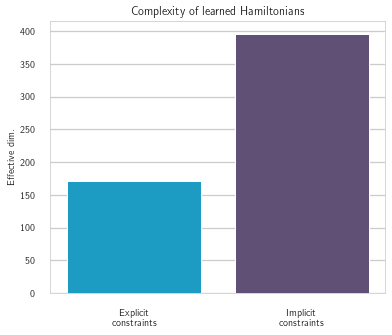

In [24]:
fig, ax = plt.subplots(figsize=(6,5))
sns.barplot(data=ed, x="network", y="ed", ax=ax,
            palette=["C0", "C3", "C4"],
            ci=95,
)
ax.set(xticklabels=["Explicit\nconstraints", "Implicit\nconstraints"],
       ylabel="Effective dim.",
       #xlabel=r"$N$"+"-pendulums",
       title="Complexity of learned Hamiltonians",
       xlabel=None,
       yscale="linear",
)
#handles, labels = ax.get_legend_handles_labels()
#ax.legend().remove()
#ax.legend(handles=handles, labels=labels)
#labels[0] = "Cartesian coordinates with explicit constraints"
#labels[1] = "Generalized coordinates with implicit constraints"

In [25]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1000
fig.savefig("eff_dim.png", bbox_inches="tight")

In [26]:
df["eig_val"].min()

0.0

In [27]:
df.groupby(["network", "batch"])["eig_val"].apply(lambda x: x[x!=0].min())

network  batch
CHNN     0        8.293953e-07
HNN      0        4.522459e-05
NN       0        2.962244e-05
Name: eig_val, dtype: float64

In [28]:
df.groupby(["network", "batch"])["eig_val"].apply(lambda x: x.nlargest(100).iloc[0])

network  batch
CHNN     0         0.005953
HNN      0        14.079761
NN       0         8.263067
Name: eig_val, dtype: float64

In [29]:
df.groupby(["network", "batch"])["eig_val"].apply(lambda x: x.nlargest(100))

network  batch      
CHNN     0      999     0.005953
                998     0.003717
                997     0.002940
                996     0.002139
                995     0.002026
                          ...   
NN       0      2904    0.048801
                2903    0.048358
                2902    0.047573
                2901    0.046947
                2900    0.046776
Name: eig_val, Length: 300, dtype: float64

In [30]:
df.groupby(["network", "batch"])["eig_val"].apply(lambda x: x.cumsum())

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
          ...    
2995    18.209942
2996    19.201660
2997    20.652617
2998    23.922644
2999    32.185711
Name: eig_val, Length: 3000, dtype: float64

In [31]:
# zero out junk eigenvalues
df["eig_val"] = (df["eig_val"] != 1.) * df["eig_val"]

In [32]:
df = df.groupby(["network", "batch"], as_index=False).apply(lambda x: x.sort_values(by="eig_val", ascending=False)).reset_index(drop=True)

In [33]:
df["eigcdf"] = df.groupby(["network", "batch"])["eig_val"].apply(lambda x: x.cumsum() / x[x!=0].sum())
df["eig_val_normalized"] = df.groupby(["network", "batch"])["eig_val"].apply(lambda x: x / x[x!=0].sum())

In [34]:
df

,network,batch,norm_sq,num_params,eig_val,eigcdf,eig_val_normalized
0,CHNN,0,695.758972,135173,0.005953,0.019157,0.019157
1,CHNN,0,695.758972,135173,0.003717,0.031118,0.011961
2,CHNN,0,695.758972,135173,0.002940,0.040579,0.009461
3,CHNN,0,695.758972,135173,0.002139,0.047464,0.006885
4,CHNN,0,695.758972,135173,0.002026,0.053985,0.006520
...,...,...,...,...,...,...,...
2995,NN,0,3091.054932,135686,0.000000,1.000000,0.000000
2996,NN,0,3091.054932,135686,0.000000,1.000000,0.000000
2997,NN,0,3091.054932,135686,0.000000,1.000000,0.000000
2998,NN,0,3091.054932,135686,0.000000,1.000000,0.000000


In [35]:
def compare(reg=1e-2):
    #df["eig_val"] = df.groupby(["network", "batch"])["eig_val"].apply(lambda x: x / x[x!=0].sum())

#     ed_chnn = df[df["network"] == "CHNN"].groupby(["network", "batch"])["eig_val"].apply(
#                             lambda x: eff_dof(x, z=reg, axis=-1)
#     ).rename("ed")
#     ed_other = df[df["network"] != "CHNN"].groupby(["network", "batch"])["eig_val"].apply(
#                             lambda x: eff_dof(x, z=reg, axis=-1)
#     ).rename("ed")
#     ed = pd.concat([ed_chnn, ed_other]).reset_index()
#     ed = ed[ed["network"] != "NN"]

    fig, axes = plt.subplots(ncols=3, figsize=(12,4))
#     sns.barplot(data=ed, x="network", y="ed", ax=axes[0],
#                 palette=["C0", "C3", "C4"],
#                 ci=95,
#     )
#     axes[0].set(xticklabels=["Explicit\nconstraints", "Implicit\nconstraints"],
#            ylabel="Effective dim.",
#            #xlabel=r"$N$"+"-pendulums",
#            title="Complexity of learned Hamiltonians",
#            xlabel=None)

    eigs = df.loc[:, ["network", "batch", "eig_val", "eigcdf", "eig_val_normalized"]]
    eigs = eigs[eigs["network"] != "NN"]
    #eigs = eigs.groupby(["network", "batch"], as_index=False).apply(lambda x: x.sort_values(by="eig_val", ascending=False)).reset_index(drop=True)
    eigs["order"] = df.groupby(["network", "batch"]).cumcount()
    eigs = eigs.rename(columns={"eig_val": "eigval"})

    sns.lineplot(data=eigs[eigs["order"] <= 100],
                 x="order", y="eigval", hue="network",
                 ax=axes[0])
    axes[0].set(yscale="log", xscale="linear")

    #axes[0].axhline(reg, ls="--", label="Regularization", c="k")
    #axes[0].legend()

    sns.lineplot(data=eigs[eigs["order"] <= 1000].rename(columns={"eig_val_normalized": "evnormalized"}),
                 x="order", y="evnormalized", hue="network",
                 ax=axes[1])
    axes[1].set(yscale="linear", xscale="linear")

    #axes[1].axhline(reg, ls="--", label="Regularization", c="k")
    #axes[1].legend()
    
    sns.lineplot(data=eigs, x="order", y="eigcdf", hue="network", ax=axes[2])

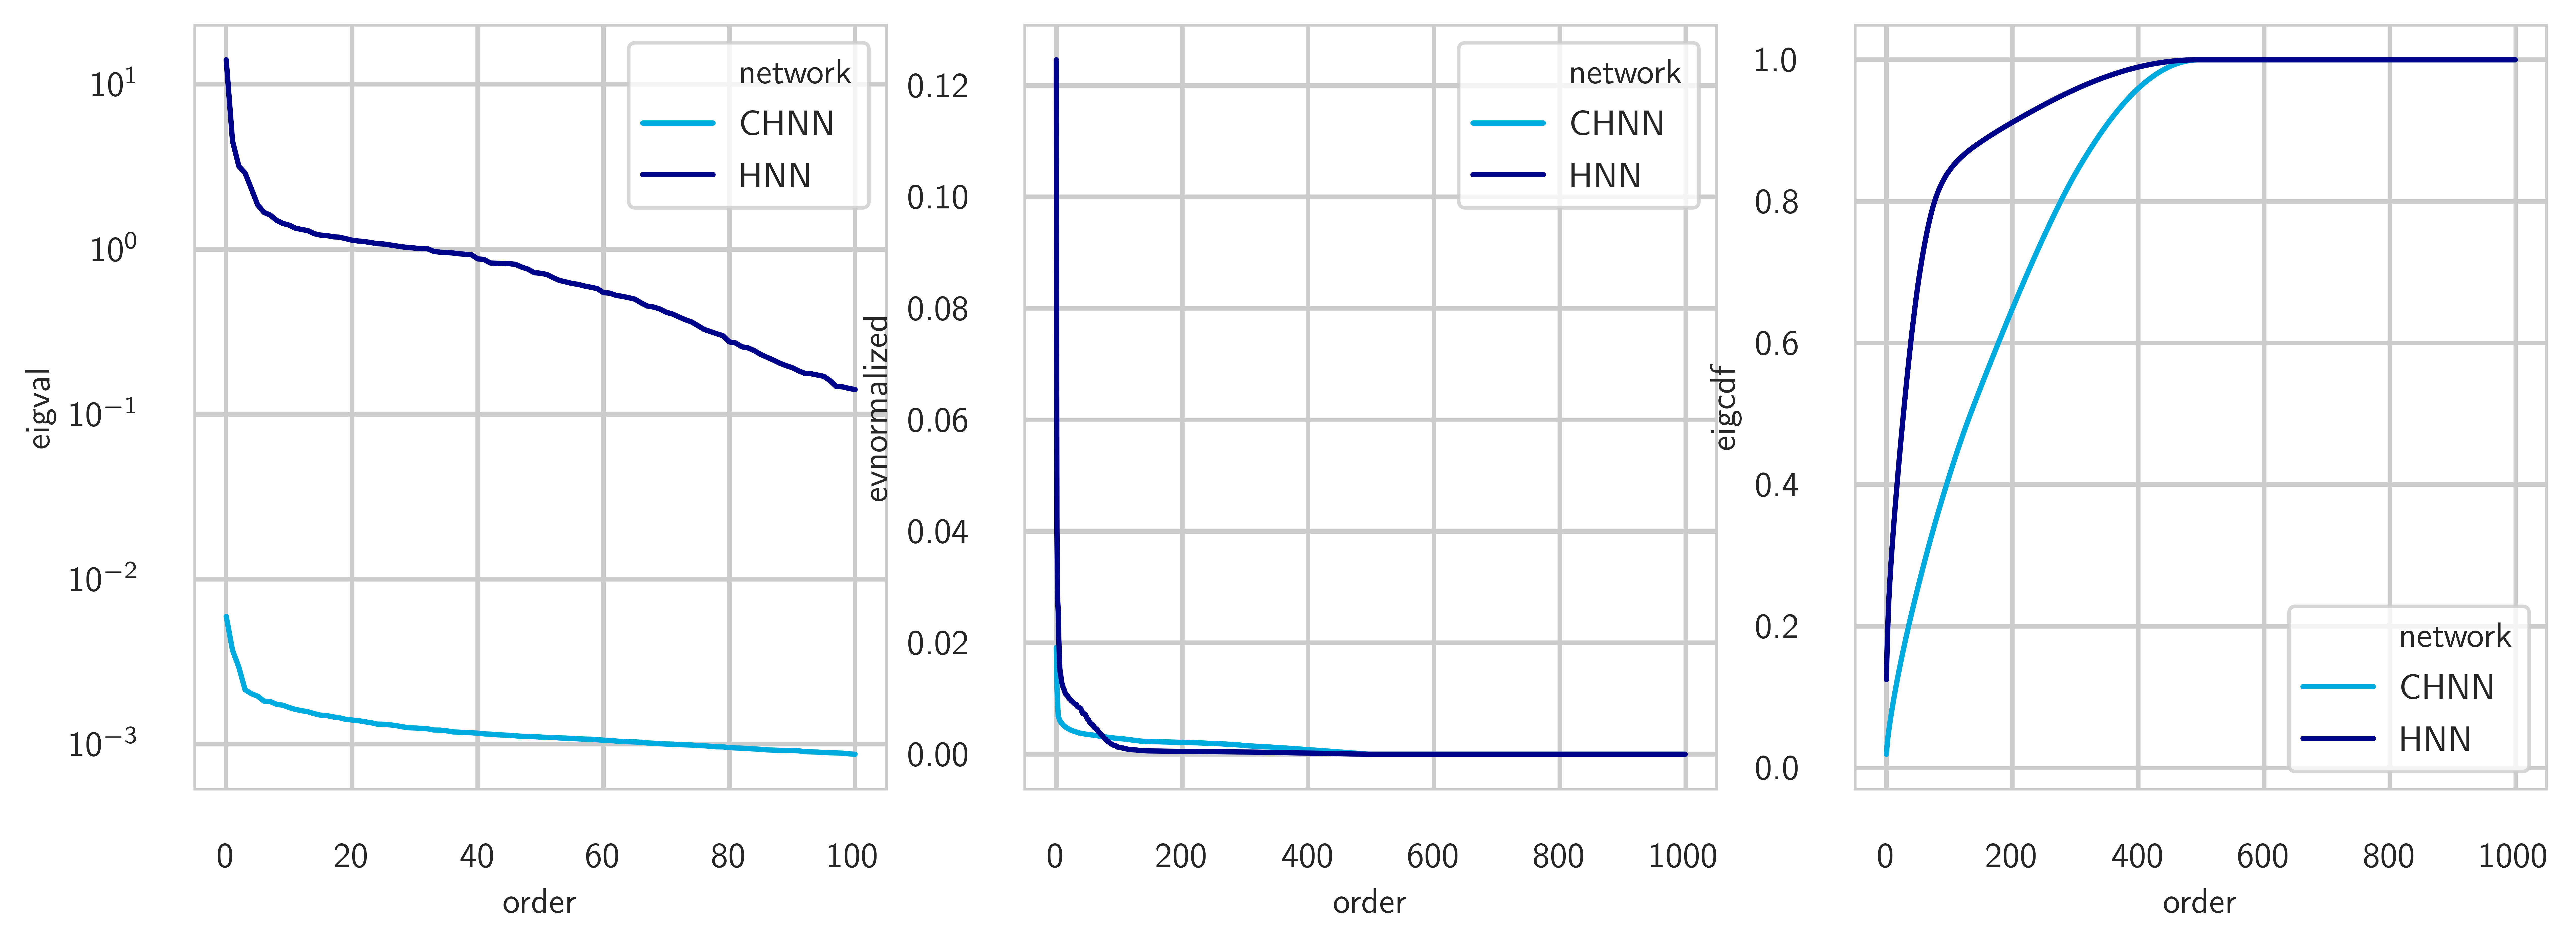

In [36]:
compare()

[(0.0, 0.005), (80.0, 180.0)]

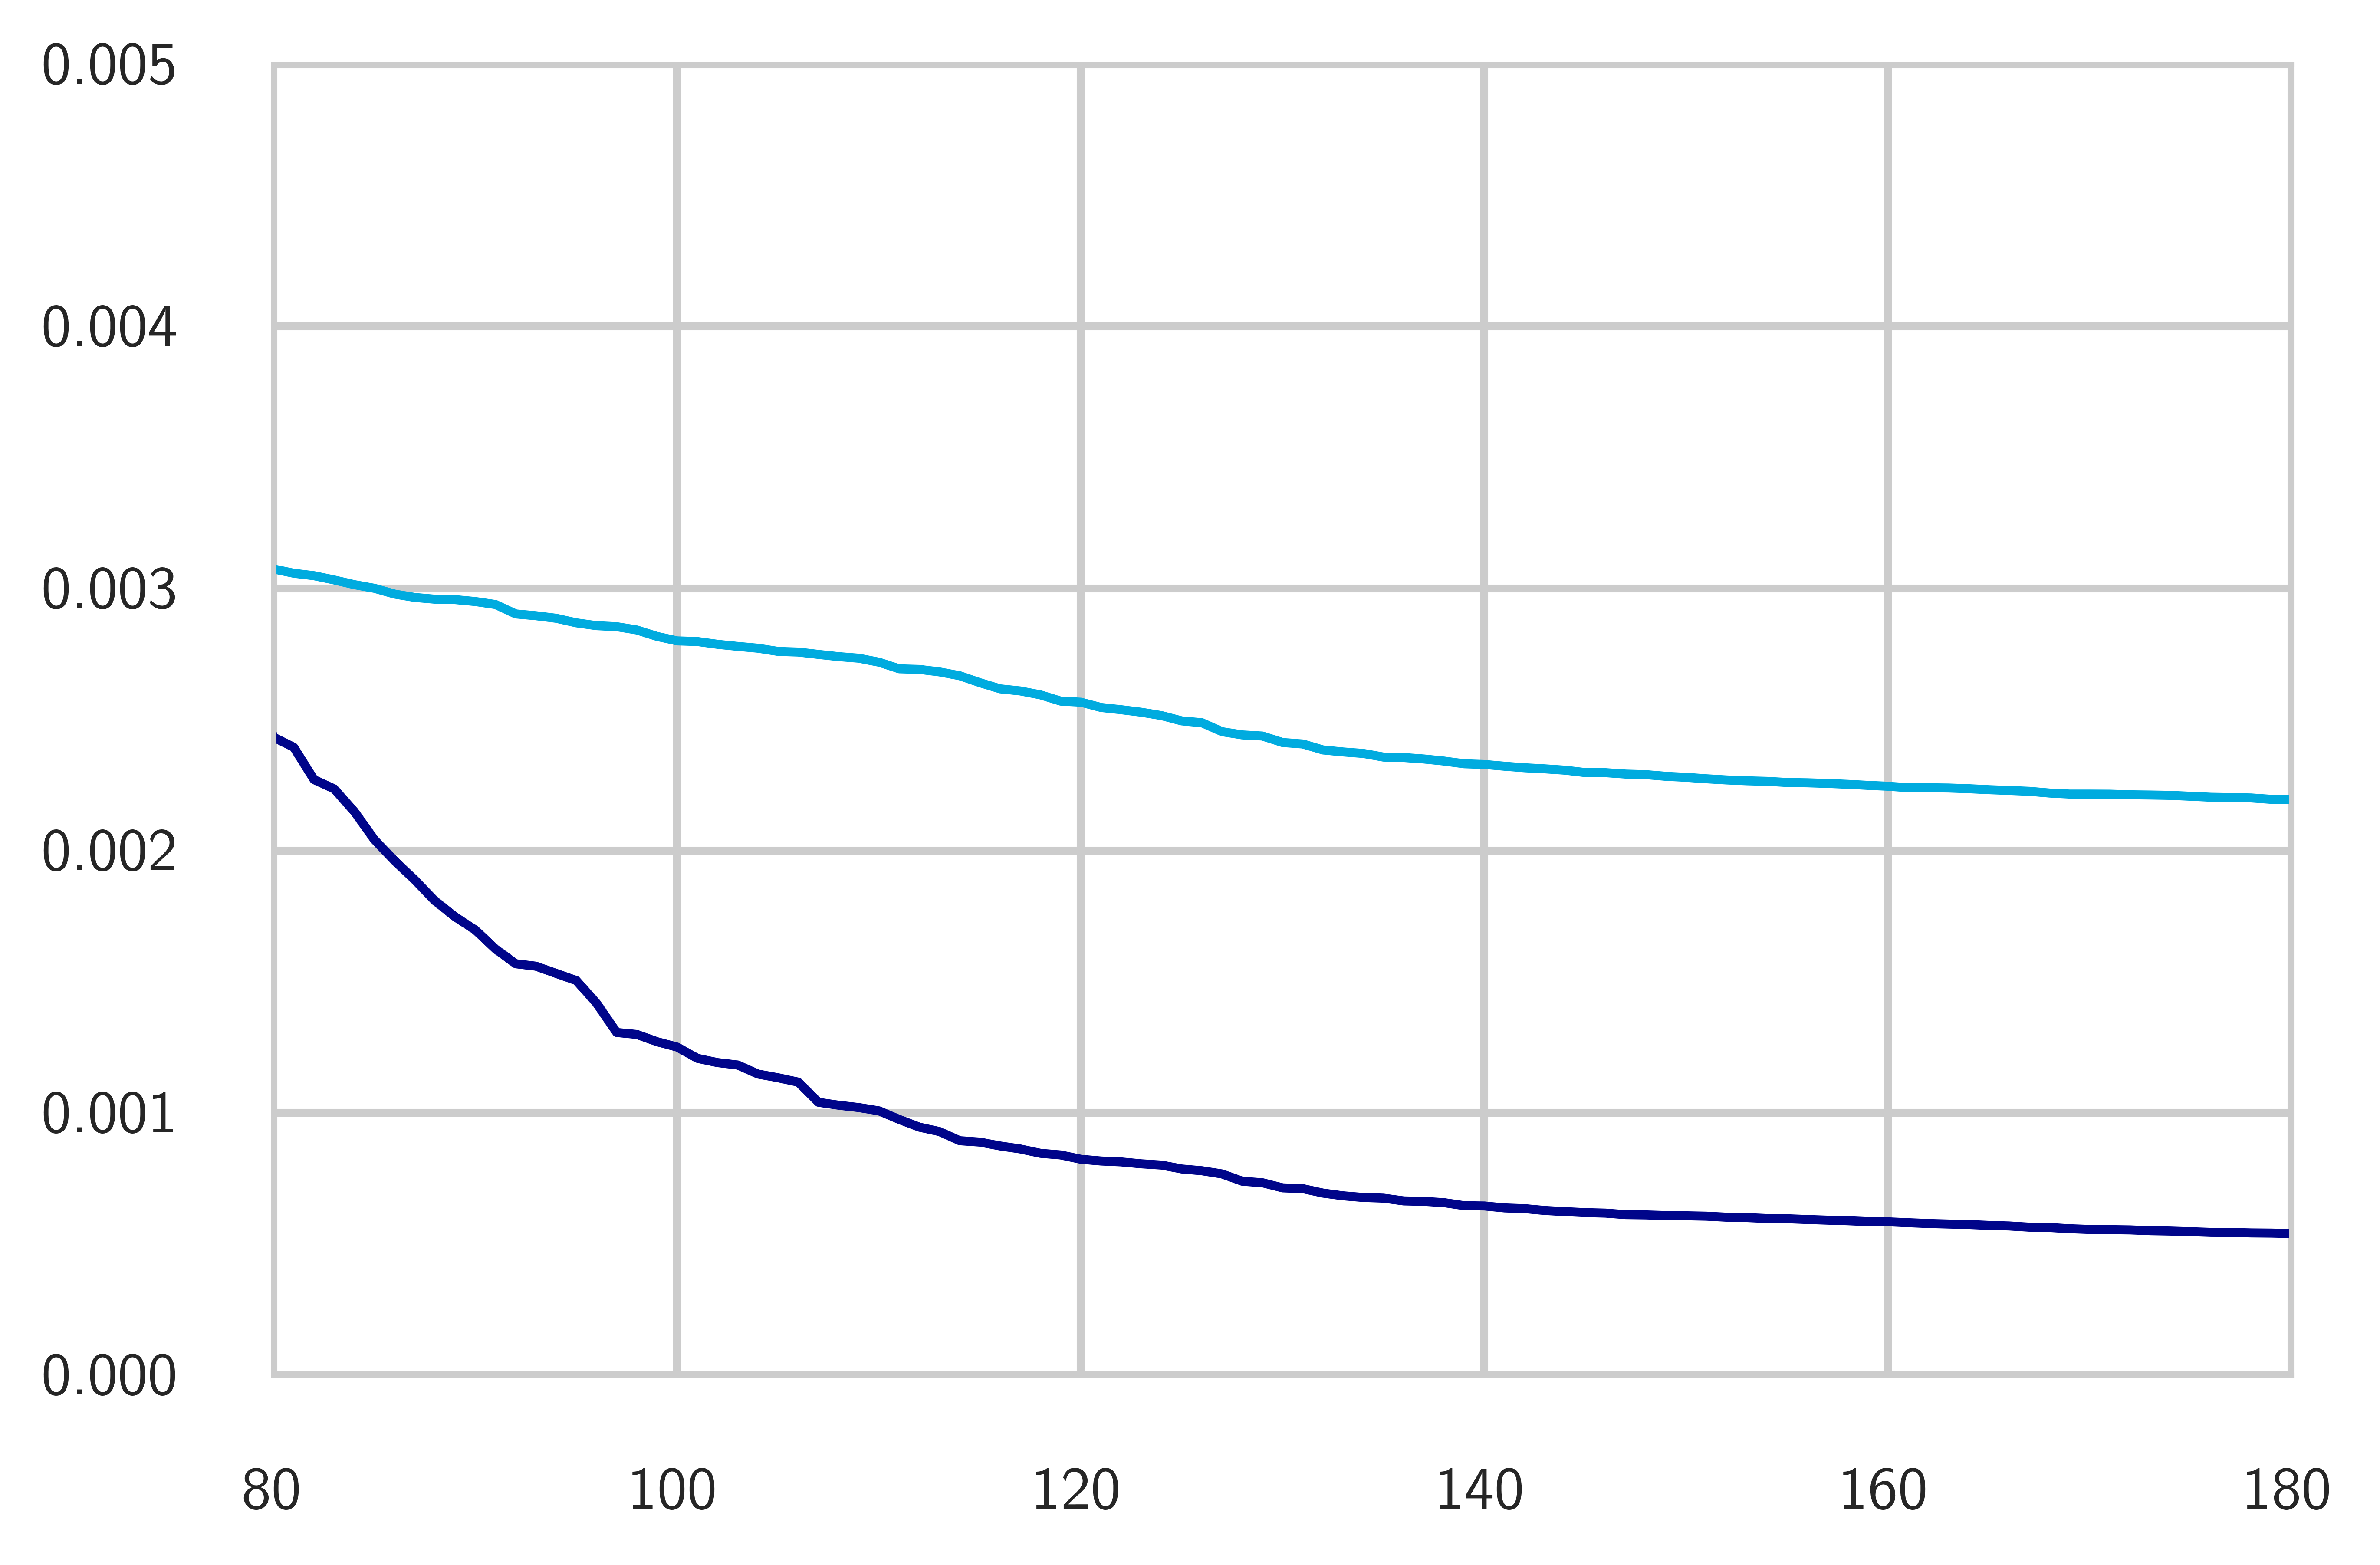

In [52]:
fig, ax = plt.subplots()
df.set_index(["network", "batch"]).loc["CHNN"]["eig_val_normalized"].reset_index(drop=True).plot(ax=ax)
df.set_index(["network", "batch"]).loc["HNN"]["eig_val_normalized"].reset_index(drop=True).plot(ax=ax)
ax.set(xlim=(80, 180), ylim=(0, 5e-3))

/home/anon/miniconda3/envs/ham37v2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


AttributeError: 'AxesSubplot' object has no property 'xlablel'

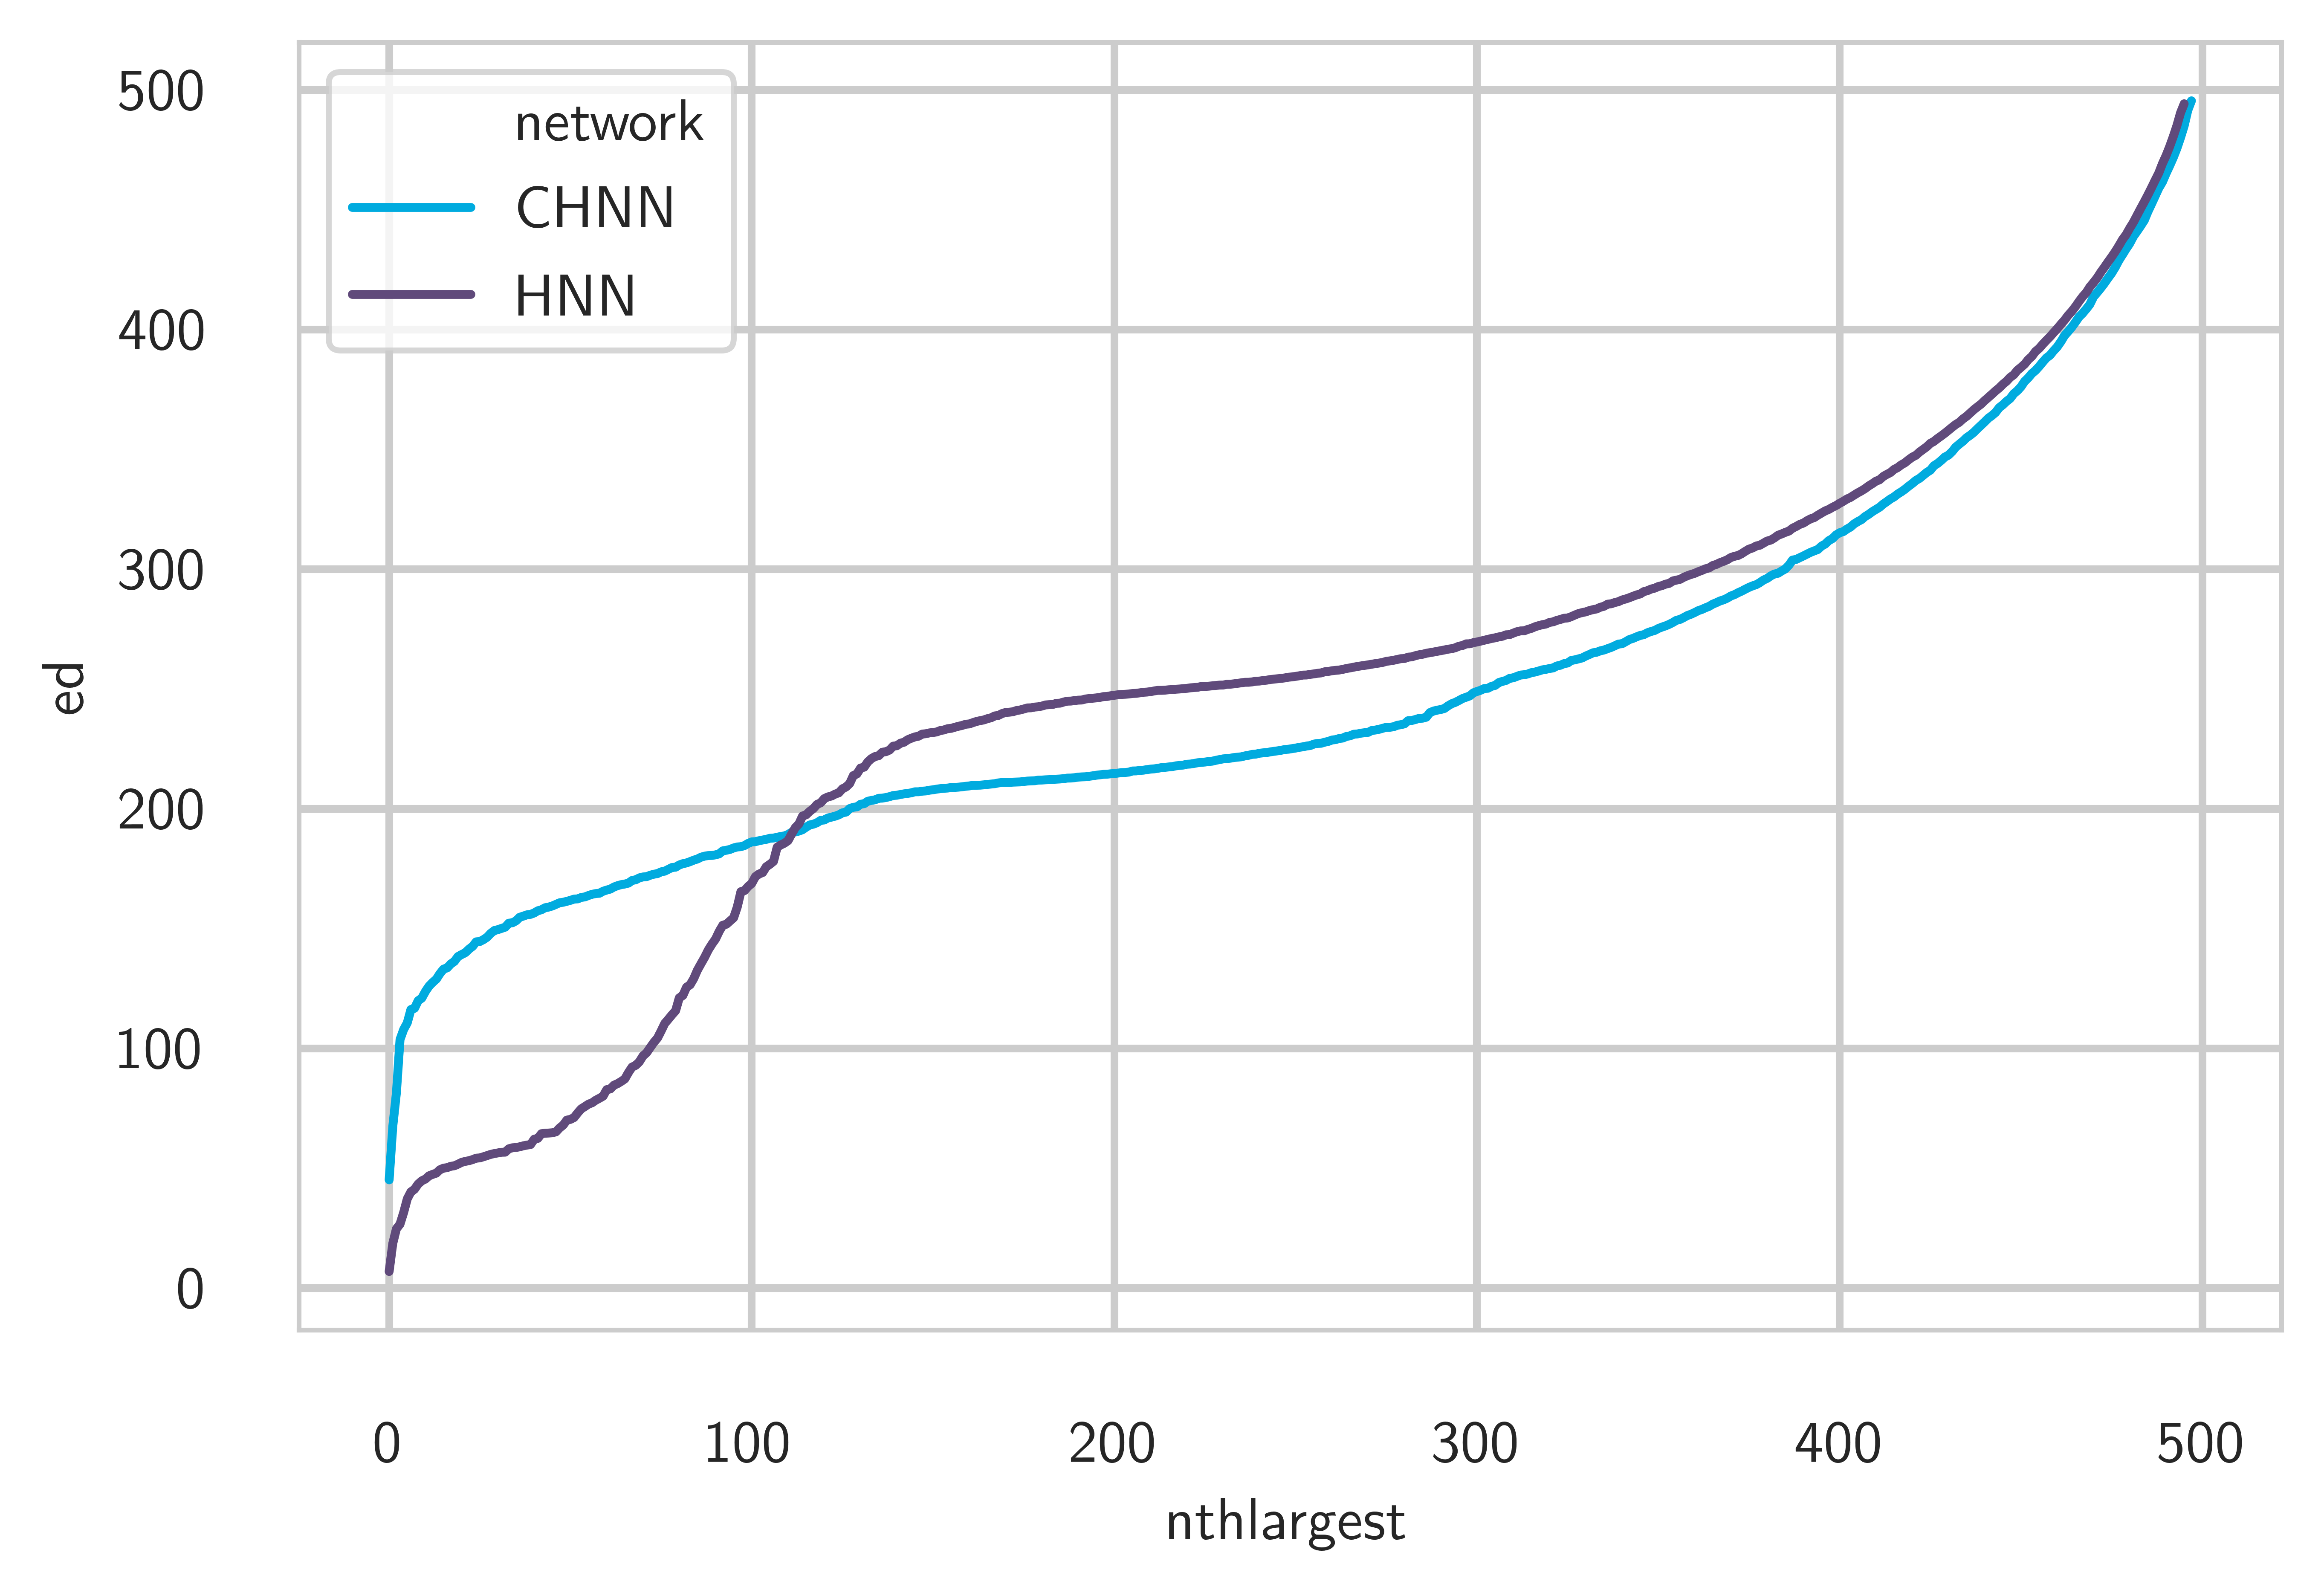

In [47]:
eds = []
for i in range(1000):
    ed_chnn = df[df["network"] == "CHNN"].groupby(["network", "batch"])["eig_val"].apply(
                            lambda x: eff_dof(x, z=x.nlargest(1000).iloc[i], axis=-1)
    ).rename("ed")
    ed_other = df[df["network"] != "CHNN"].groupby(["network", "batch"])["eig_val"].apply(
                            lambda x: eff_dof(x, z=x.nlargest(1000).iloc[i], axis=-1)
    ).rename("ed")
    ed = pd.concat([ed_chnn, ed_other]).reset_index()
    ed = ed[ed["network"] != "NN"]
    ed["nthlargest"] = i
    eds.append(ed)
    
eds = pd.concat(eds)

    
fig, axes = plt.subplots()
axes = [axes]

sns.lineplot(data=eds, x="nthlargest", y="ed", hue="network", ax=axes[0],
            palette=["C0", "C3"],
)
axes[0].set(xlabel="n where z=nthlargest")
# axes[0].set(xticklabels=["Explicit\nconstraints", "Implicit\nconstraints"],
#        ylabel="Effective dim.",
#        #xlabel=r"$N$"+"-pendulums",
#        title="Complexity of learned Hamiltonians",
#        xlabel=None)

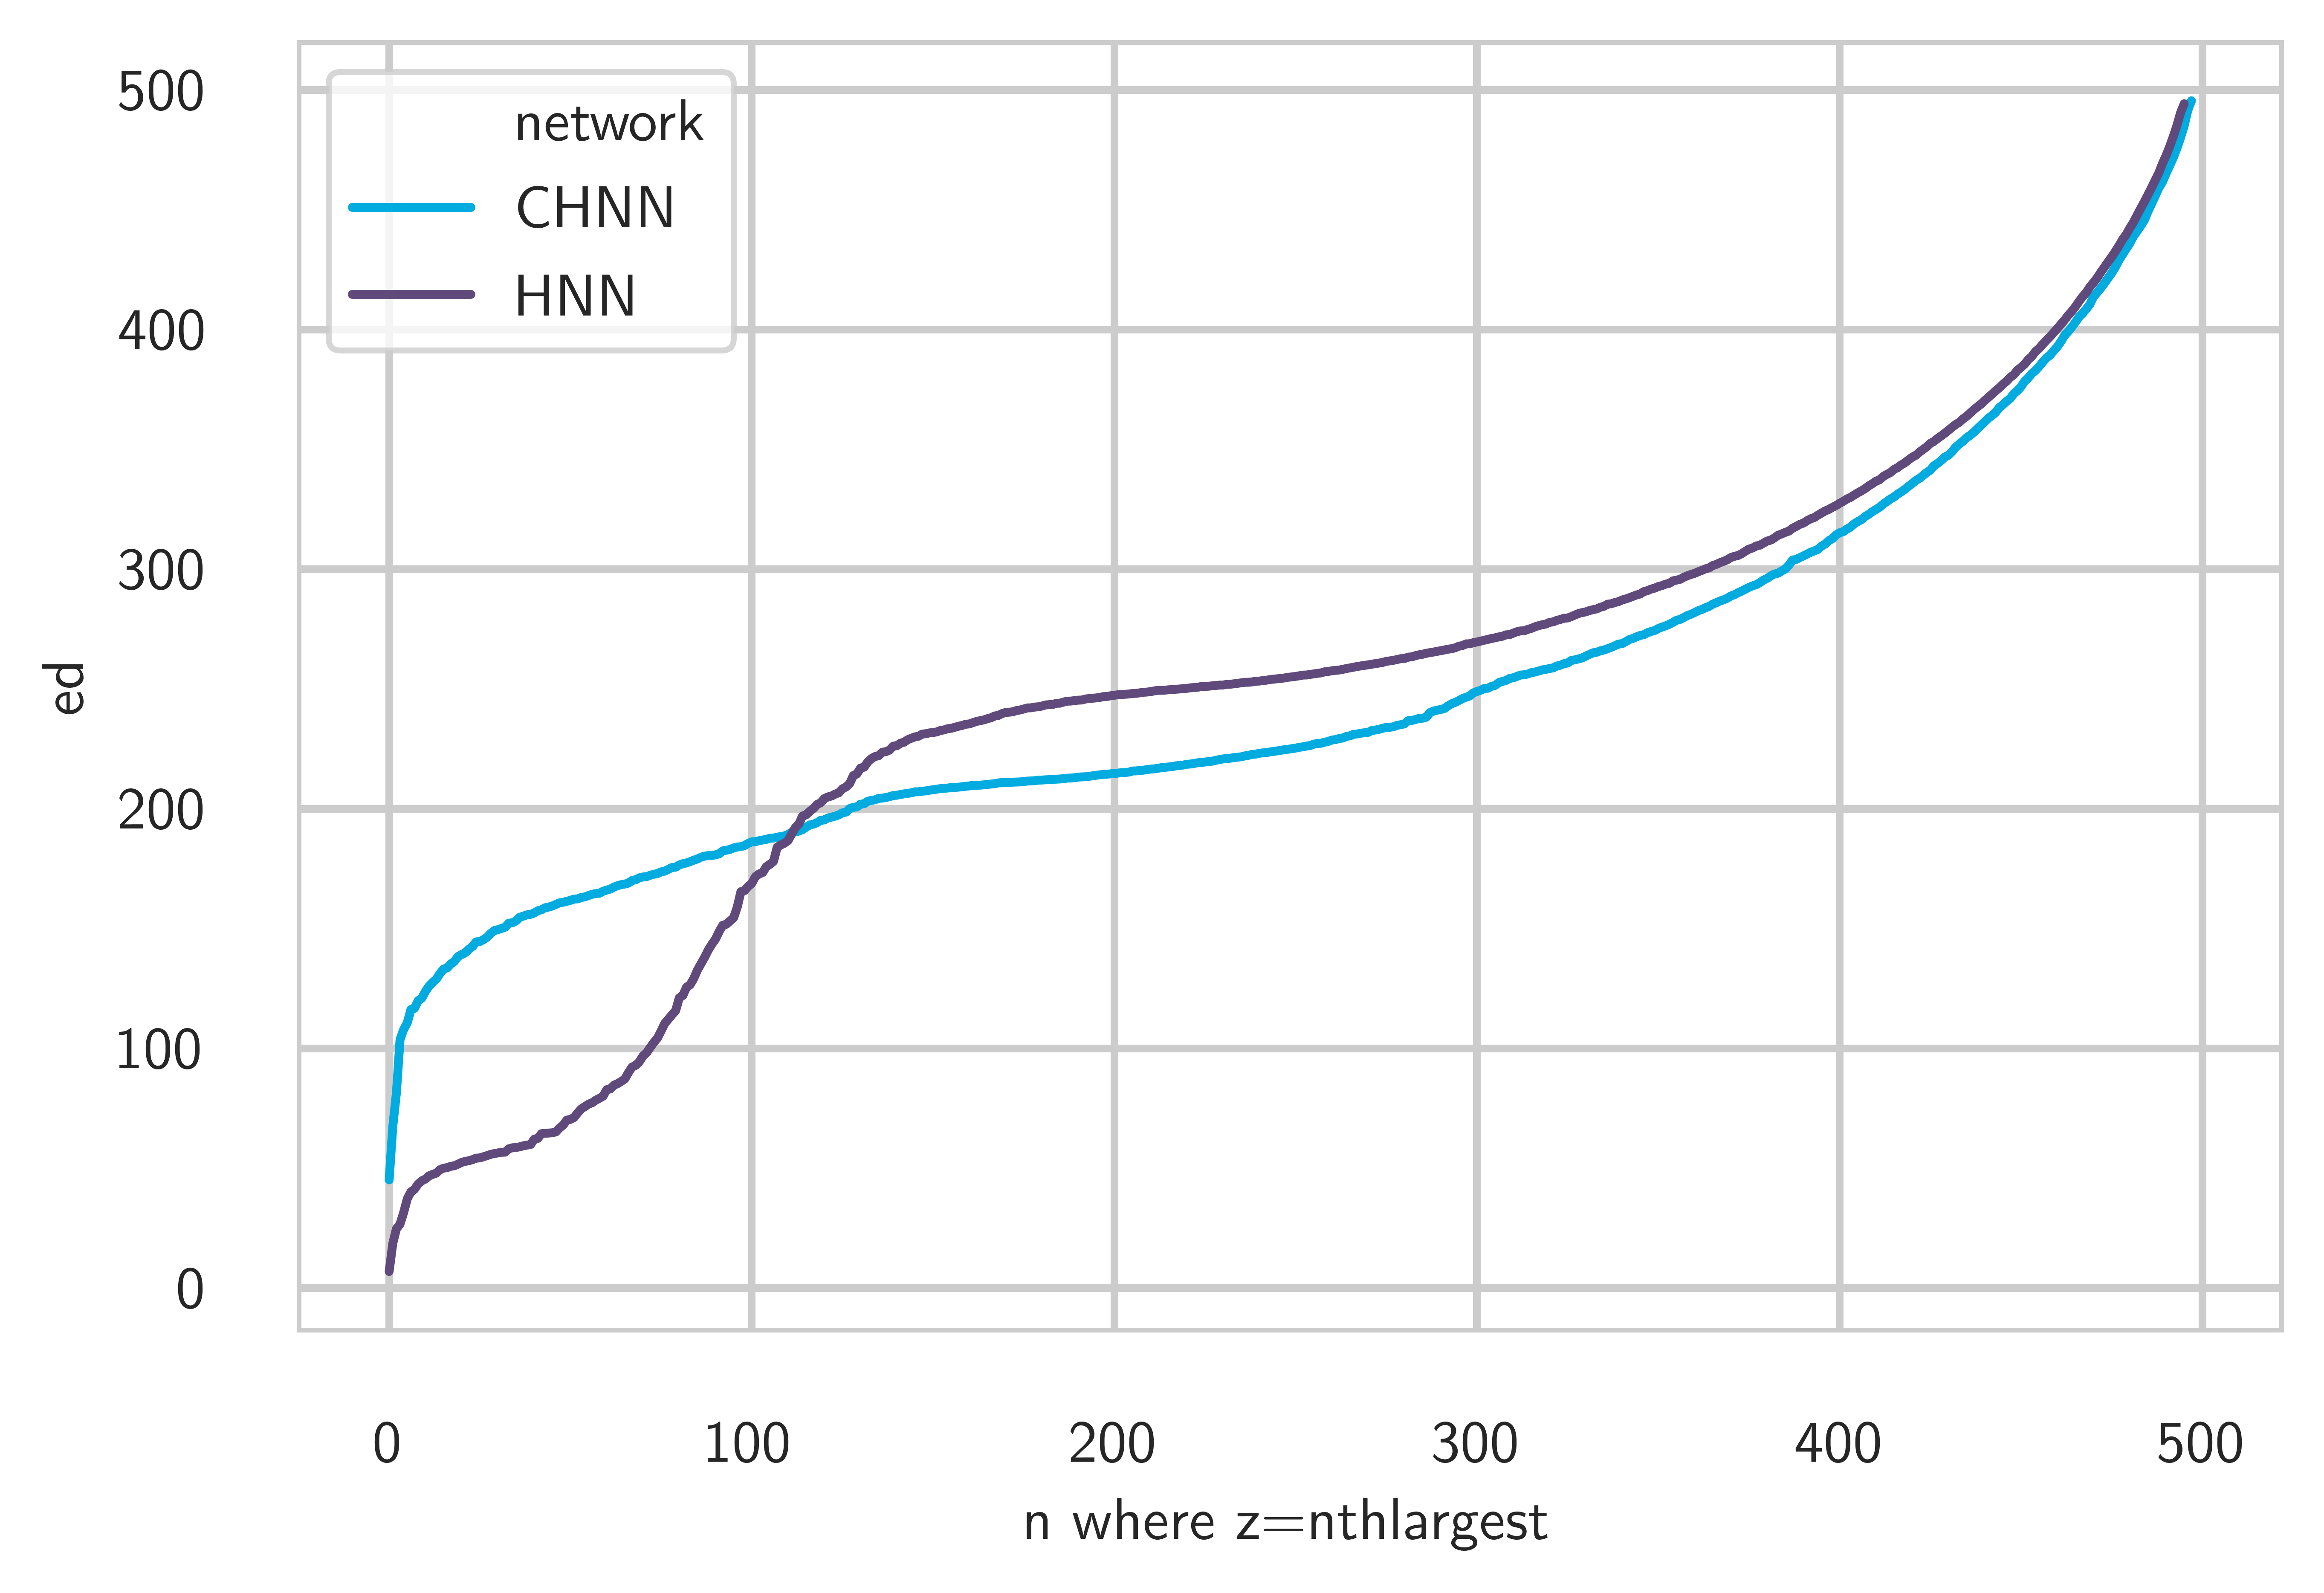

In [48]:
axes[0].set(xlabel="n where z=nthlargest")
fig